In [3]:
from emcee.backends import HDFBackend
import corner
import matplotlib.pyplot as plt
import numpy as np
import emcee
from scipy.interpolate import RegularGridInterpolator
import numpy as np
from multiprocessing import Pool
from lenstronomy.Cosmo.micro_lensing import einstein_radius
from parameter_manager import ParameterManager
import astropy.units as u

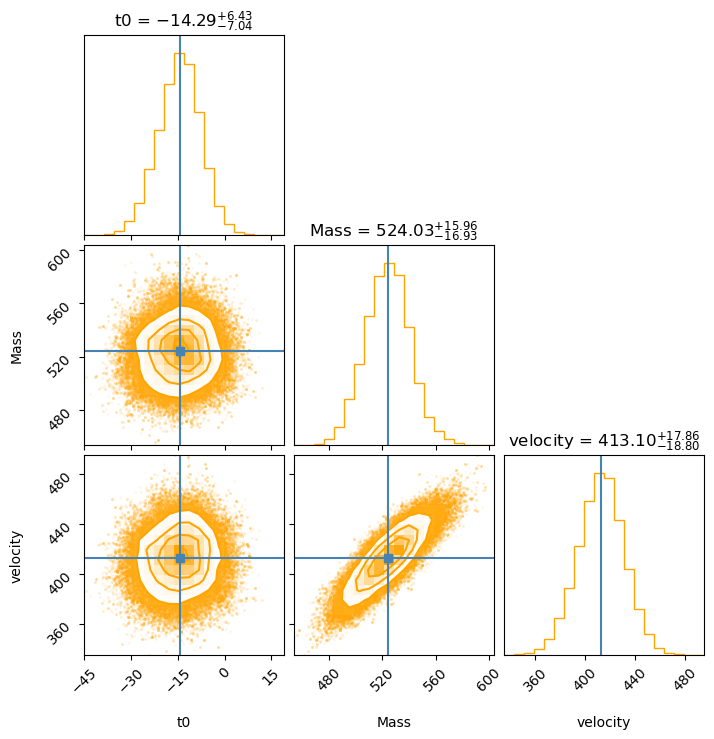

In [5]:
backend = HDFBackend('backend_v3.h5')
chain = backend.get_chain(discard=500, flat=True)
fig = corner.corner(chain, color='orange', show_titles=True, labels=['t0', 'Mass', 'velocity'], truths=np.percentile(chain, 50, axis=0))
# plt.savefig('./MCMC-shape-only.pdf')

In [2]:

"""
real parameter:
d_s = 8000
d_l = 4000              # pc
M0 = 500                # M_sol
u_min = 0.2
velocity = 400          # km/s
"""

with open('ellip_table_webb.npy', 'rb') as f:
    theta_E0 = np.load(f)
    u0 = np.load(f)
    table = np.load(f)
    table_err = np.load(f)

interpolator = RegularGridInterpolator((u0, theta_E0), table, bounds_error=False, fill_value=None)
interpolator_err = RegularGridInterpolator((u0, theta_E0), table_err, bounds_error=False, fill_value=None)

pc2km = u.pc.to(u.km)
sec2day = u.s.to(u.day)
arcsec2rad = u.arcsec.to(u.rad)

def get_data(t, t0, M, v, d_l, d_s, u_min):
    """
    get curve at a given parameter.
    unit:
        t, t0: day
        M: M_sol,
        v: km/s,
        d_l, d_s: pc
    """
    theta_E = einstein_radius(M, d_l, d_s)
    t_E = theta_E*arcsec2rad*d_l*pc2km/v*sec2day
    u = np.sqrt(u_min*u_min + ((t-t0)/t_E)**2)
    new_x = np.stack((u, np.ones_like(u)*theta_E), axis=-1)
    y = interpolator(new_x)
    y_err = interpolator_err(new_x)
    if np.isnan(y).any():
        print(t, t0, M, v, d_l, d_s, u_min)
        import sys
        sys.exit(1)
    return y, y_err

t_obs, e_obs, err_obs = np.load('mock2_webb.npy')

In [6]:
t0, m, v = np.percentile(chain, 50, axis=0)
d_l, d_s, u_min = 4000, 8000, 0.2
res, err_sys = get_data(t_obs, t0, m, v, d_l, d_s, u_min)

<ErrorbarContainer object of 3 artists>

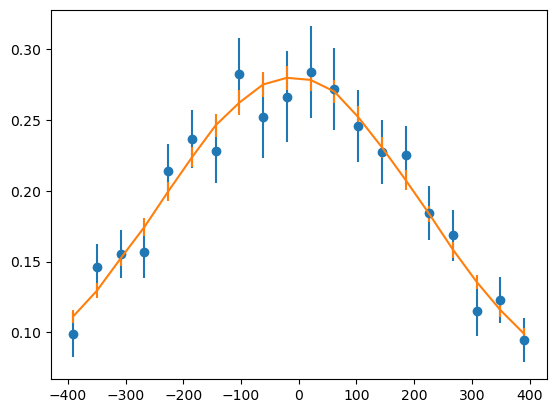

In [11]:
plt.errorbar(t_obs, e_obs, err_obs, fmt='o')
plt.errorbar(t_obs, res, err_sys, fmt='-')

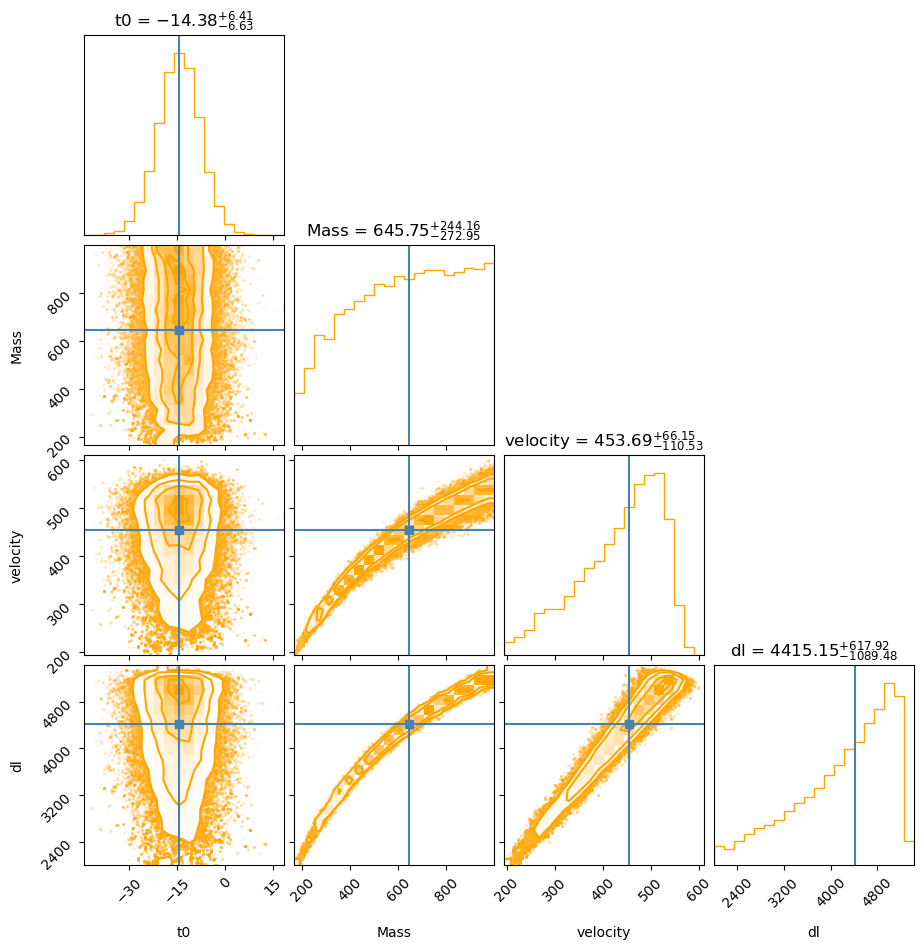

In [4]:
backend = HDFBackend('backend_free_dl.h5')
chain = backend.get_chain(discard=500, flat=True)
fig = corner.corner(chain, color='orange', show_titles=True, labels=['t0', 'Mass', 'velocity', 'dl'], truths=np.percentile(chain, 50, axis=0))
# plt.savefig('./MCMC-shape-only-2.pdf')

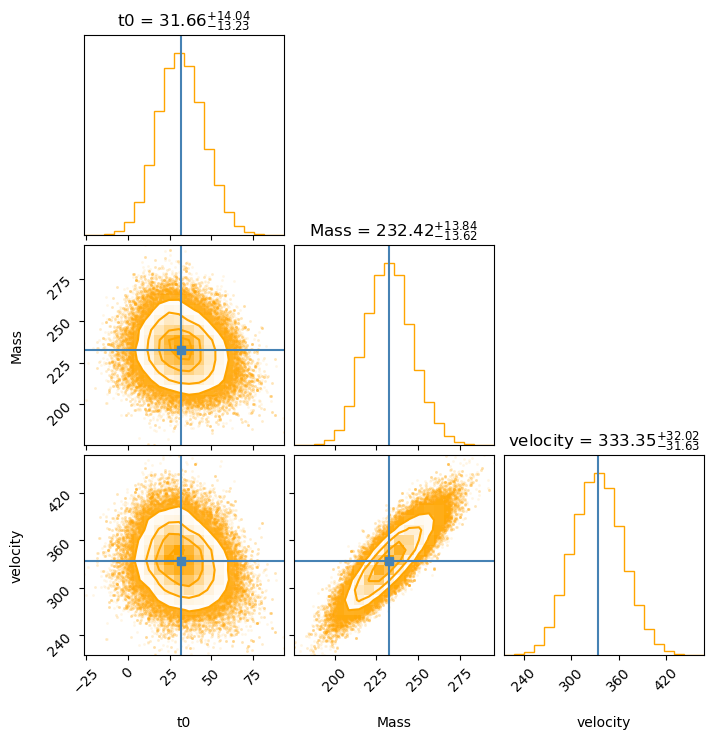

In [4]:
"""
d_s = 8000
d_l = 4000              # pc
M0 = 200                # M_sol
u_min = 0.2
velocity = 300          # km/s
"""
backend = HDFBackend('backend_new_para.h5')
chain = backend.get_chain(discard=500, flat=True)
fig = corner.corner(chain, color='orange', show_titles=True, labels=['t0', 'Mass', 'velocity'], truths=np.percentile(chain, 50, axis=0))
# plt.savefig('./MCMC-shape-only.pdf')

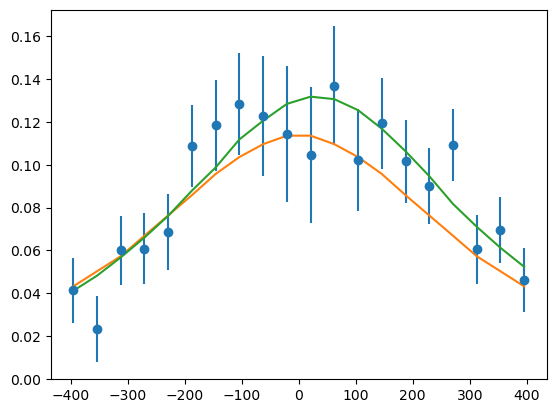

In [7]:
with open('ellip_table_webb.npy', 'rb') as f:
    theta_E0 = np.load(f)
    u0 = np.load(f)
    table = np.load(f)
    table_err = np.load(f)

interpolator = RegularGridInterpolator((u0, theta_E0), table, bounds_error=False, fill_value=None)
interpolator_err = RegularGridInterpolator((u0, theta_E0), table_err, bounds_error=False, fill_value=None)

pc2km = u.pc.to(u.km)
sec2day = u.s.to(u.day)
arcsec2rad = u.arcsec.to(u.rad)

def get_data(t, t0, M, v, d_l, d_s, u_min):
    """
    get curve at a given parameter.
    unit:
        t, t0: day
        M: M_sol,
        v: km/s,
        d_l, d_s: pc
    """
    theta_E = einstein_radius(M, d_l, d_s)
    t_E = theta_E*arcsec2rad*d_l*pc2km/v*sec2day
    u = np.sqrt(u_min*u_min + ((t-t0)/t_E)**2)
    new_x = np.stack((u, np.ones_like(u)*theta_E), axis=-1)
    y = interpolator(new_x)
    y_err = interpolator_err(new_x)
    if np.isnan(y).any():
        print(t, t0, M, v, d_l, d_s, u_min)
        import sys
        sys.exit(1)
    return y, y_err

t_obs, e_obs, err_obs = np.load('mock3_webb.npy')
t0, m, v = np.percentile(chain, 50, axis=0)
d_l, d_s, u_min = 4000, 8000, 0.2
res, err_sys = get_data(t_obs, t0, m, v, d_l, d_s, u_min)

d_s = 8000
d_l = 4000              # pc
m = 200                # M_sol
u_min = 0.2
v = 300          # km/s
t0 = 0
res_true, _ = get_data(t_obs, t0, m, v, d_l, d_s, u_min)


plt.errorbar(t_obs, e_obs, err_obs, fmt='o')
# plt.fill_between(t_obs, res-err_sys, res+err_sys)
plt.plot(t_obs, res_true)
plt.plot(t_obs, res)
# plt.errorbar(t_obs, res, err_sys, fmt='-')

In [3]:
chi2 = -backend.get_log_prob()

In [7]:
chi2.min()

9.842326682717447

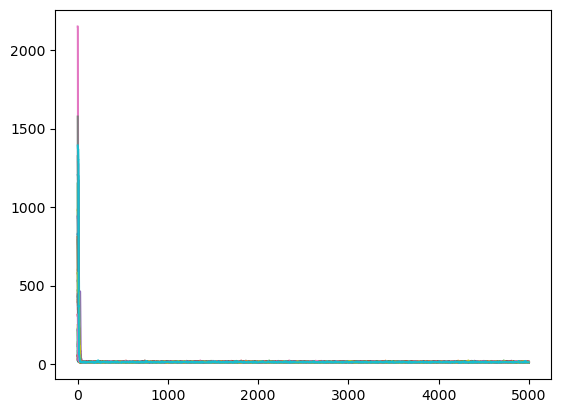

In [6]:
for i in range(chi2.shape[1]):
    plt.plot(chi2[:,i])